### Lab 10 - Fine-Tune VGG16 for Bird Classification

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from collections import Counter

- <strong>Data Directory Setup:</strong> Set the main data directory and form paths for training and testing data.

- <strong>Count Images per Class:</strong> Define a function to count images in each class, then apply it to the training set.

- <strong>Select Top 3 Classes:</strong> Use a Counter to find class occurrences, select the top 3 classes with the most images.


In [3]:
# Set your data directory
data_dir = str(os.getcwd())+"/birds_data"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Function to count the number of images in each class


def count_images_per_class(directory):
    classes = os.listdir(directory)
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            class_counts[class_name] = len(images)
    return class_counts


# Get the counts for each class in the training set
train_class_counts = count_images_per_class(train_dir)

# Select the top 3 classes with the highest number of images
selected_classes = [class_name for class_name,
                    count in Counter(train_class_counts).most_common(3)]

selected_classes

['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

#### Directory Creation for Selected Classes
- New directories (`selected_train_dir` and `selected_test_dir`) are created to store only the selected classes.

#### Ensure Directory Existence
- Directories are created if they don't exist using `os.makedirs` with `exist_ok=True`.

#### Copy Images for Selected Classes
- For each selected class, images from the original training and testing sets are copied to the new directories.
- The process is repeated for both training and testing sets if needed.


In [4]:
# Create a new directory to store only the selected classes
selected_train_dir = os.path.join(data_dir, 'selected_train')
selected_test_dir = os.path.join(data_dir, 'selected_test')

# Create directories if they don't exist
os.makedirs(selected_train_dir, exist_ok=True)
os.makedirs(selected_test_dir, exist_ok=True)

# Copy images for the selected classes to the new directories
for class_name in selected_classes:
    source_dir = os.path.join(train_dir, class_name)
    destination_dir = os.path.join(selected_train_dir, class_name)
    os.makedirs(destination_dir, exist_ok=True)
    images = os.listdir(source_dir)
    for image in images:
        source_path = os.path.join(source_dir, image)
        destination_path = os.path.join(destination_dir, image)
        shutil.copy(source_path, destination_path)

    # Repeat the process for the test set if needed
    source_dir = os.path.join(test_dir, class_name)
    destination_dir = os.path.join(selected_test_dir, class_name)
    os.makedirs(destination_dir, exist_ok=True)
    images = os.listdir(source_dir)
    for image in images:
        source_path = os.path.join(source_dir, image)
        destination_path = os.path.join(destination_dir, image)
        shutil.copy(source_path, destination_path)

#### Use Selected Directories
- Update `train_dir` and `test_dir` to use the directories containing only the selected classes.

#### Data Augmentation
- Apply data augmentation to the training data using `ImageDataGenerator` with various transformations like rotation, shift, shear, zoom, and horizontal flip.

#### Flow From Directory
- Generate augmented batches of training data using `flow_from_directory` with specified parameters such as target size, batch size, class mode, and selected class names.


In [5]:
# Use the selected directories for training and testing
train_dir = selected_train_dir
test_dir = selected_test_dir

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=selected_classes
)

Found 744 images belonging to 3 classes.


#### Load Pre-trained VGG16 Model
- Load the pre-trained VGG16 model with ImageNet weights, excluding the top classification layers.

#### Build Custom Top Layers
- Construct a new model by adding custom layers on top of the pre-trained VGG16 base model, including flattening, dense, dropout, and softmax layers.

#### Compile the Model
- Compile the model with an Adam optimizer, categorical crossentropy loss, and accuracy metric.


In [6]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(224, 224, 3))

# Build custom top layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(selected_classes), activation='softmax'))

# Compile the model
model.compile(
    optimizer=optimizers.Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Fine-Tune the Model
- Fine-tune the model using the training data generated by `train_generator` for 10 epochs.

#### Evaluate on Test Set
- Evaluate the fine-tuned model on the test set using `test_generator` with specified parameters such as target size, batch size, class mode, and selected class names.


In [7]:
# Fine-tune the model
history = model.fit(
    train_generator,
    epochs=10,
    verbose=1
)

# Evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=selected_classes
)

Epoch 1/10
24/24 [==============================] - 251s 10s/step - loss: 2.4223 - accuracy: 0.3145
Epoch 2/10
24/24 [==============================] - 253s 11s/step - loss: 1.1425 - accuracy: 0.3454
Epoch 3/10
24/24 [==============================] - 236s 10s/step - loss: 1.1681 - accuracy: 0.3696
Epoch 4/10
24/24 [==============================] - 222s 9s/step - loss: 1.0982 - accuracy: 0.3508
Epoch 5/10
24/24 [==============================] - 222s 9s/step - loss: 1.0976 - accuracy: 0.3535
Epoch 6/10
24/24 [==============================] - 232s 10s/step - loss: 1.0974 - accuracy: 0.3535
Epoch 7/10
24/24 [==============================] - 254s 11s/step - loss: 1.0976 - accuracy: 0.3535
Epoch 8/10
24/24 [==============================] - 261s 11s/step - loss: 1.0976 - accuracy: 0.3535
Epoch 9/10
24/24 [==============================] - 261s 11s/step - loss: 1.0978 - accuracy: 0.3535
Epoch 10/10
24/24 [==============================] - 263s 11s/step - loss: 1.0972 - accuracy: 0.3535
F

#### Calculate Metrics
- Calculate the test loss and accuracy of the fine-tuned model using `model.evaluate` on the `test_generator`.

#### Confusion Matrix
- Compute and display the confusion matrix using the true labels (`y_true`) and predicted labels (`y_pred`).

#### Classification Report
- Generate and print the classification report, including precision, recall, and F1-score, using `classification_report` with target names specified as class labels.


In [12]:
# Calculate metrics
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Classification Report
class_labels = {i: class_name for i, class_name in enumerate(selected_classes)}
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels.values()))


1/1 - 1s - loss: 1.0996 - accuracy: 0.3333 - 1s/epoch - 1s/step
1/1 [==============================] - 1s 1s/step
Confusion Matrix:
[[5 0 0]
 [5 0 0]
 [5 0 0]]
Classification Report:
                  precision    recall  f1-score   support

    RUFOUS TREPE       0.33      1.00      0.50         5
     HOUSE FINCH       0.00      0.00      0.00         5
D-ARNAUDS BARBET       0.00      0.00      0.00         5

        accuracy                           0.33        15
       macro avg       0.11      0.33      0.17        15
    weighted avg       0.11      0.33      0.17        15



c:\Users\Sam17\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sam17\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sam17\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### Precision-Recall Curve for Each Class
- Calculate precision, recall, and area under the curve (AUC) for each class using `precision_recall_curve` and `auc` functions.
- Compute micro-average precision, recall, and AUC using label binarization.
- Plot precision-recall curves for each class and the micro-average curve using Matplotlib.


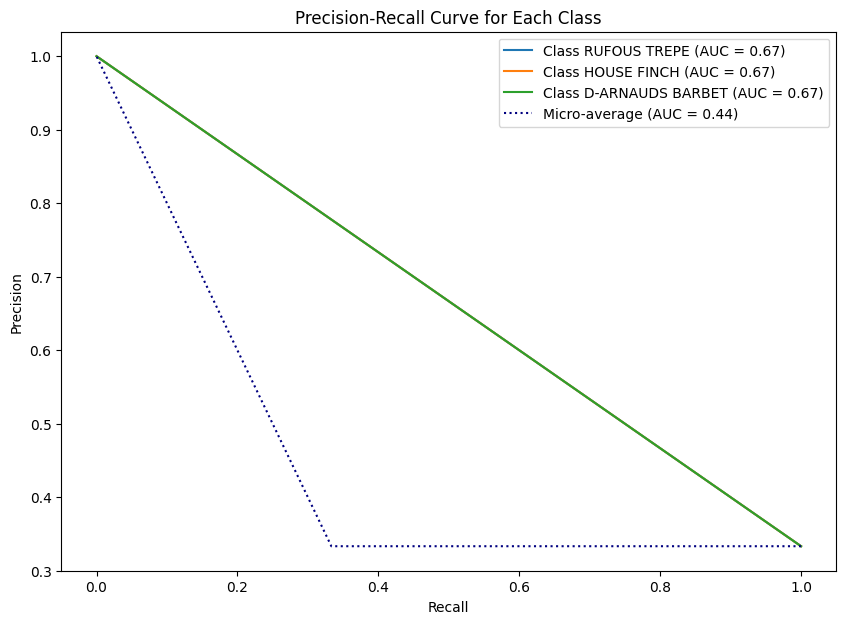

In [14]:
# Precision-Recall Curve for each class
from sklearn.preprocessing import label_binarize
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(len(selected_classes)):
    precision[i], recall[i], _ = precision_recall_curve(
        (y_true == i).astype(int),
        predictions[:, i]
    )
    pr_auc[i] = auc(recall[i], precision[i])

# Micro-average Precision-Recall Curve
precision["micro"], recall["micro"], _ = precision_recall_curve(
    label_binarize(y_true, classes=range(len(selected_classes))).ravel(),
    predictions.ravel()
)
pr_auc["micro"] = auc(recall["micro"], precision["micro"])

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(10, 7))

for i in range(len(selected_classes)):
    plt.plot(
        recall[i],
        precision[i],
        label=f'Class {selected_classes[i]} (AUC = {pr_auc[i]:.2f})'
    )

plt.plot(
    recall["micro"],
    precision["micro"],
    label=f'Micro-average (AUC = {pr_auc["micro"]:.2f})',
    color='navy',
    linestyle=':',
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.show()